In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# Métricas para regresión
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
# Modelos de regresión
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
# División y validación
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Interpretabilidad
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
# Pipeline
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# DATASET LOADING

In [4]:
df = pd.read_csv('train.csv')
df

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


# EDA

In [5]:
df.drop_duplicates(keep="first", inplace=True)
df.shape

(21197, 82)

<Axes: >

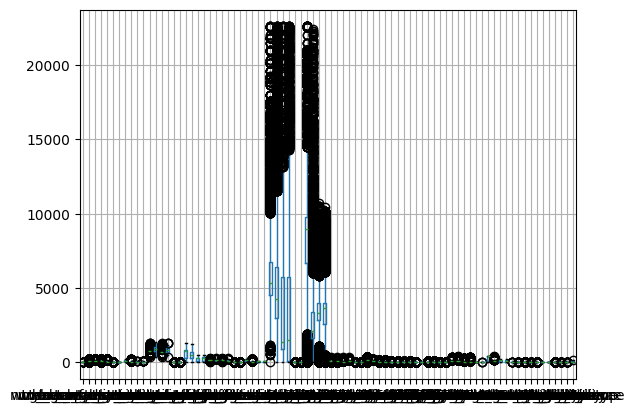

In [6]:
df.boxplot()

In [7]:
outlier_mask = pd.DataFrame(False, index=df.index, columns=df.columns)

for col in df.select_dtypes(include=["float64", "int64"]).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    #Bounds
    l = q1 - 1.5 * iqr
    h = q3 + 1.5 * iqr
    #Set that is an outlier
    outlier_mask[col] = (df[col] < l) | (df[col] > h)
num_rows_with_outliers = outlier_mask.any(axis=1).sum()
print((num_rows_with_outliers / df.shape[0])*100, "%")

54.71528989951408 %


## NAN & INFINITE TREATMENT

In [8]:
nan_counts = df.isna().sum()
print(nan_counts.sum())

0


No hay ningún nulo.

In [9]:
print(np.isposinf(df).any().any())
print(np.isneginf(df).any().any())

False
False


In [10]:
total_infinitos = np.isinf(df).sum().sum()
porcentaje_infinitos = (total_infinitos / df.size) * 100
print(f"Porcentaje total de infinitos: {porcentaje_infinitos:.4f}%")

Porcentaje total de infinitos: 0.0000%


In [11]:
df = df.replace([np.inf, -np.inf], np.nan)  # convierte inf a NaN
df = df.dropna()  # elimina filas con NaN (o usa imputación)
df.shape

(21197, 82)

## LOG NORMAL ANALYSIS


In [12]:
from scipy.stats import skew

data = df

log_candidates = []
sqrt_candidates = []
no_transform_needed = []
functions = {} #Guardará las transformaciones por columna para luego el predictor

threshold = 0.5  # umbral para considerar sesgo

for col in data.columns:
  vals = data[col].dropna()
  original_skew = skew(vals)

  if abs(original_skew) > threshold:
    log_skew = skew(np.log1p(vals))
    sqrt_skew = skew(np.sqrt(vals))  # sqrt requiere >=0, se asegura

    # Compara cuál transformación mejora más la simetría
    improvements = {
      'log': abs(log_skew),
      'sqrt': abs(sqrt_skew),
      'original': abs(original_skew)
    }
    best_transform = min(improvements, key=improvements.get)

    if best_transform == 'log':
      log_candidates.append(col)
      functions[col] = np.log1p
    elif best_transform == 'sqrt':
      sqrt_candidates.append(col)
      functions[col] = np.sqrt
    else:
      no_transform_needed.append(col)
      functions[col] = None
  else:
    functions[col] = None
    no_transform_needed.append(col)

print("Columnas que mejorarían con log:")
print(log_candidates)
print("\nColumnas que mejorarían con sqrt:")
print(sqrt_candidates)
print("\nColumnas sin sesgo significativo o sin mejora con transformaciones:")
print(no_transform_needed)

Columnas que mejorarían con log:
['wtd_mean_atomic_mass', 'wtd_gmean_atomic_mass', 'mean_fie', 'gmean_fie', 'wtd_mean_atomic_radius', 'wtd_gmean_atomic_radius', 'mean_Density', 'wtd_mean_Density', 'gmean_Density', 'wtd_gmean_Density', 'mean_FusionHeat', 'wtd_mean_FusionHeat', 'gmean_FusionHeat', 'wtd_gmean_FusionHeat', 'range_FusionHeat', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 'gmean_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'mean_Valence', 'wtd_mean_Valence', 'gmean_Valence', 'wtd_gmean_Valence', 'wtd_std_Valence']

Columnas que mejorarían con sqrt:
['mean_atomic_mass', 'gmean_atomic_mass', 'wtd_range_atomic_mass', 'wtd_range_atomic_radius', 'wtd_range_Density', 'std_Density', 'mean_ElectronAffinity', 'gmean_ElectronAffinity', 'range_ElectronAffinity', 'wtd_mean_ThermalConductivity', 'wtd_range_ThermalConductivity', 'wtd_range_Valence', 'critical_temp']

Columnas sin sesgo significativo o sin mejora con transformaciones:
['number_of_elements', 'en

In [13]:
#Actualiza con su función respectiva
for col in data.columns:
  if functions[col] is not None:
    df[col] = functions[col](df[col])

## CORRELATIONS

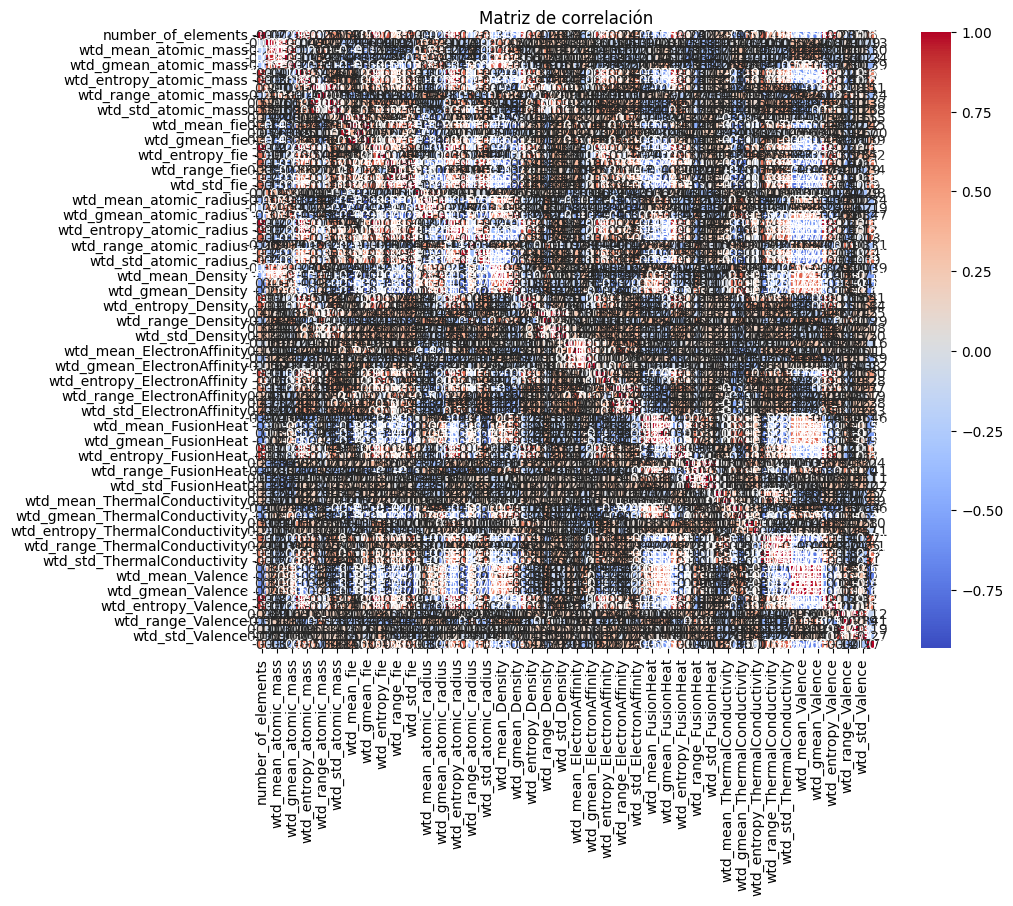

In [14]:
corr_matrix = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Matriz de correlación")
plt.show()

In [15]:
corr_matrix

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
number_of_elements,1.000000,-0.073394,-0.217039,-0.223065,-0.359649,0.939160,0.881645,0.682231,-0.222268,0.513378,...,-0.650854,-0.611157,-0.665050,0.967733,0.892339,0.231166,-0.349361,0.104977,0.060622,0.654531
mean_atomic_mass,-0.073394,1.000000,0.801916,0.933351,0.692896,-0.036734,-0.027654,0.208200,0.396984,0.271780,...,0.237605,0.342238,0.255099,-0.081603,-0.072900,-0.090415,0.109875,-0.068377,-0.085147,-0.127903
wtd_mean_atomic_mass,-0.217039,0.801916,1.000000,0.805492,0.938681,-0.165375,-0.276784,0.000138,0.651411,0.064664,...,0.475573,0.485783,0.477090,-0.224986,-0.164946,0.009515,0.204580,0.027915,0.105110,-0.298881
gmean_atomic_mass,-0.223065,0.933351,0.805492,1.000000,0.802509,-0.110136,-0.152420,-0.093301,0.383510,-0.047476,...,0.364417,0.470991,0.390565,-0.228885,-0.234736,-0.157036,0.195545,-0.120592,-0.128864,-0.240841
wtd_gmean_atomic_mass,-0.359649,0.692896,0.938681,0.802509,1.000000,-0.258717,-0.389562,-0.255474,0.600842,-0.191473,...,0.598908,0.595848,0.608030,-0.371202,-0.324481,-0.025951,0.300226,0.005997,0.071993,-0.387947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
range_Valence,0.231166,-0.090415,0.009515,-0.157036,-0.025951,0.202615,0.160727,0.208417,0.098282,0.192044,...,0.157729,0.008201,0.076119,0.154586,0.203941,1.000000,0.170479,0.973828,0.872857,-0.117881
wtd_range_Valence,-0.349361,0.109875,0.204580,0.195545,0.300226,-0.230180,-0.427576,-0.283567,0.564450,-0.200233,...,0.606250,0.464365,0.603191,-0.293256,-0.522326,0.170479,1.000000,0.233211,0.189706,-0.413354
std_Valence,0.104977,-0.068377,0.027915,-0.120592,0.005997,0.087600,0.055999,0.134609,0.133250,0.144158,...,0.230235,0.085404,0.149963,0.034118,0.089626,0.973828,0.233211,1.000000,0.891227,-0.192026
wtd_std_Valence,0.060622,-0.085147,0.105110,-0.128864,0.071993,0.051712,0.017874,0.110261,0.173373,0.125444,...,0.302173,0.135085,0.214517,0.015878,0.109771,0.872857,0.189706,0.891227,1.000000,-0.274843


Se saca la conclusión de que necesitamos un PCA.

## N COMPONENTS PCA

In [16]:
features = df.loc[:, df.columns != 'critical_temp']
scaler = StandardScaler()
features = scaler.fit_transform(features)
threshold = 0.95
for comp in range(1, 30):
  pca = PCA(n_components=comp)
  pca.fit_transform(features)
  if sum(pca.explained_variance_ratio_) > threshold:
    print(comp)
    break

16


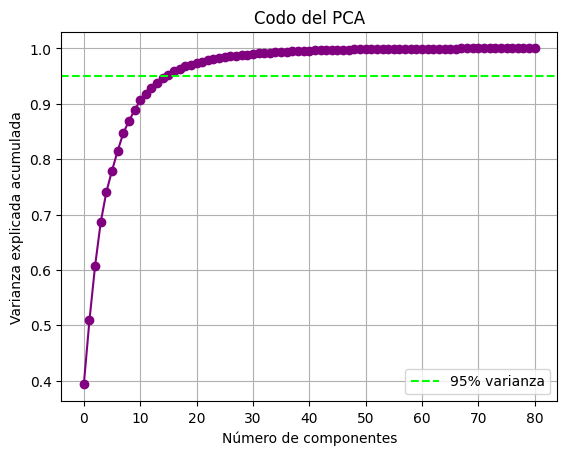

In [17]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA()
pca.fit(features_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained, marker='o', color='purple')
plt.axhline(0.95, color='lime', linestyle='--', label='95% varianza')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Codo del PCA")
plt.legend()
plt.grid(True)
plt.show()

La cantidad correcta de componentes para el PCA es 16.

# MODELS

In [18]:
X = df.drop(columns=['critical_temp'])
y = df['critical_temp']
test_size = 0.30
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)

print('Training: %d. Test: %d' % (len(y_train), len(y_test)))

Training: 14837. Test: 6360


In [19]:
pipelines = []
# Modelos con PCA (lineales y basados en vectores)
pipelines.append(('pipLinear', make_pipeline(StandardScaler(), PCA(n_components=16), LinearRegression())))
pipelines.append(('pipRidge', make_pipeline(StandardScaler(), PCA(n_components=16), Ridge())))
pipelines.append(('pipLasso', make_pipeline(StandardScaler(), PCA(n_components=16), Lasso())))
pipelines.append(('pipElasticNet', make_pipeline(StandardScaler(), PCA(n_components=16), ElasticNet())))
pipelines.append(('pipBayesianRidge', make_pipeline(StandardScaler(), PCA(n_components=16), BayesianRidge())))
pipelines.append(('pipHuber', make_pipeline(StandardScaler(), PCA(n_components=16), HuberRegressor())))
pipelines.append(('pipSGD', make_pipeline(StandardScaler(), PCA(n_components=16), SGDRegressor())))
pipelines.append(('pipPassiveAggressive', make_pipeline(StandardScaler(), PCA(n_components=16), PassiveAggressiveRegressor())))

# Modelos sin PCA (basados en árboles o vecinos)
pipelines.append(('pipRegTrees', make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=20))))
pipelines.append(('pipRandomForest', make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=20, max_depth=20))))
pipelines.append(('pipGradientBoost', make_pipeline(StandardScaler(), GradientBoostingRegressor())))
pipelines.append(('pipAdaBoost', make_pipeline(StandardScaler(), AdaBoostRegressor())))
pipelines.append(('pipBagging', make_pipeline(StandardScaler(), BaggingRegressor())))
pipelines.append(('pipSVR', make_pipeline(StandardScaler(), SVR())))
pipelines.append(('pipKNN', make_pipeline(StandardScaler(), KNeighborsRegressor())))
pipelines.append(('pipXGB', make_pipeline(StandardScaler(), XGBRegressor())))

In [20]:
results = []
names = []
seed = 7
kfold = KFold(n_splits=3, random_state=seed, shuffle= True)
# CV for every pipeline
for pipelinename, pipeline in pipelines:
  cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(pipelinename)
  print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

pipLinear: -3.10118150329666 (0.015324915101151877)
pipRidge: -3.1011806065699776 (0.015325805326166536)
pipLasso: -3.9862370920264745 (0.07320708666020742)
pipElasticNet: -3.6407754298162622 (0.06129448709182782)
pipBayesianRidge: -3.101153778762598 (0.015399628353482634)
pipHuber: -3.129907382233558 (0.024009798130279775)
pipSGD: -3.1471346100660527 (0.022361287398568658)
pipPassiveAggressive: -6.590670021532303 (0.8520600377294396)
pipRegTrees: -1.2599856250806152 (0.06955948289029318)
pipRandomForest: -0.7660363535346626 (0.005082677595907584)
pipGradientBoost: -1.2392902185915273 (0.028432837330153945)
pipAdaBoost: -2.6336378187003593 (0.08550958383067656)
pipBagging: -0.8098737313522667 (0.013196943132377358)
pipSVR: -1.4427780389408096 (0.03102411810319784)
pipKNN: -0.9933750841287837 (0.02469664727007992)
pipXGB: -0.790792843877773 (0.01827317477630089)


In [21]:
mean_scores = np.array([r.mean() for r in results])

# Índices de los 3 mejores (mayor score negativo MSE = mejor)
top3_idx = mean_scores.argsort()[::-1][:3]

print("\nTop 3 mejores regresores:")
for i in top3_idx:
    print(f"{names[i]}: {mean_scores[i]:.5f}")


Top 3 mejores regresores:
pipRandomForest: -0.76604
pipXGB: -0.79079
pipBagging: -0.80987


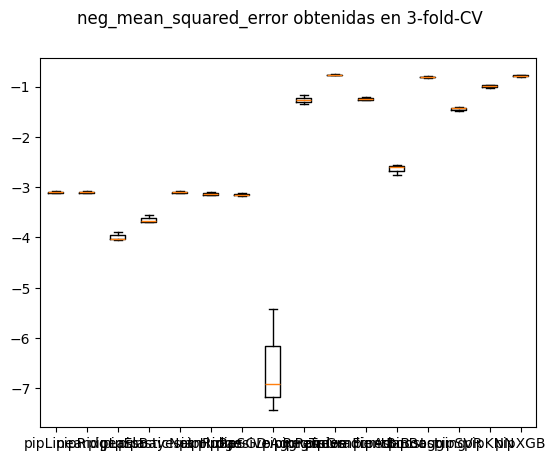

In [22]:
fig = plt.figure()
fig.suptitle('neg_mean_squared_error obtenidas en 3-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [23]:
voting_reg = VotingRegressor(
    estimators=[
        ("xgboost", pipelines[15][1]),
        ("rforest", pipelines[9][1]),
        ("bagging", pipelines[12][1])
    ]
)

In [24]:
voting_reg.fit(X_train, y_train)
accuracy = voting_reg.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9332


In [25]:
def NMSE(X_test, y_test, model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return -mse

In [26]:
print(f"Neg MSE: {NMSE(X_test, y_test, voting_reg):.4f}")

Neg MSE: -0.6190


Se concluye que el mejor modelo es el de VotingRegressor con esos 3 regresores seleccionados.

# MODEL TUNNING

In [27]:
param_grid = {
    # Parámetros para XGBoost
    'xgboost__xgbregressor__n_estimators': [50, 100, 200],
    'xgboost__xgbregressor__learning_rate': [0.01, 0.1],
    'xgboost__xgbregressor__max_depth': [3, 5],

    # Parámetros para RandomForest
    'rforest__randomforestregressor__n_estimators': [50, 100],
    'rforest__randomforestregressor__max_depth': [10, 20],

    # Parámetros para Bagging
    'bagging__baggingregressor__n_estimators': [10, 50, 100],
    'bagging__baggingregressor__max_samples': [0.5, 0.9, 1.0],
}

In [28]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    voting_reg, param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [ ]:
random_search.fit(X_train, y_train)
modelr = random_search.best_estimator_
modelr

Fitting 3 folds for each of 20 candidates, totalling 60 fits


VotingRegressor(estimators=[('xgboost',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_pol...
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))])),
                            ('rforest',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(max_depth=20,
                                                                    n_estimators=50))])),
                            ('bagging',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('baggingregressor',
                                              BaggingRegressor(max_samples=0.5,
                                                               n_estimators=50))]))])

In [ ]:
random_search.best_params_

{'xgboost__xgbregressor__n_estimators': 100,
 'xgboost__xgbregressor__max_depth': 5,
 'xgboost__xgbregressor__learning_rate': 0.1,
 'rforest__randomforestregressor__n_estimators': 50,
 'rforest__randomforestregressor__max_depth': 20,
 'bagging__baggingregressor__n_estimators': 50,
 'bagging__baggingregressor__max_samples': 0.5}

In [36]:
modelr = VotingRegressor(
    estimators=[
        ("xgboost", make_pipeline(StandardScaler(), XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1))),
        ("rforest", make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, max_depth=20))),
        ("bagging", make_pipeline(StandardScaler(), BaggingRegressor(n_estimators=100, max_samples=0.9)))
    ]
)

In [37]:
modelr.fit(X_train, y_train)

VotingRegressor(estimators=[('xgboost',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_pol...
                                                           multi_strategy=None,
                                                           n_estimators=200,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))])),
                            ('rforest',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(max_depth=20))])),
                            ('bagging',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('baggingregressor',
                                              BaggingRegressor(max_samples=0.9,
                                                               n_estimators=100))]))])

In [38]:
print(f"Neg MSE: {NMSE(X_test, y_test, modelr):.4f}")

Neg MSE: -0.6107


In [39]:
modelr.score(X_test, y_test)

0.9341163762888948

Mean squared error: 0.610728448477035
Mean absolute error: 0.4862738434936144
Explained variance score: 0.9341763898072621
R2 score: 0.9341163762888948


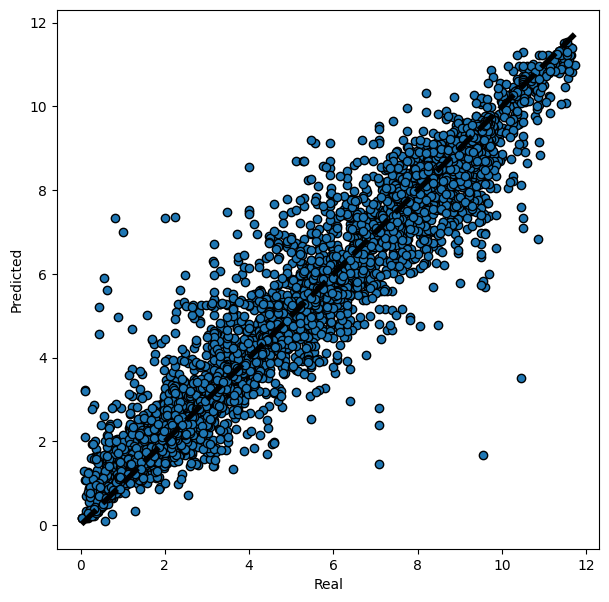

In [40]:
y_predicted = modelr.predict(X_test)
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))
# Plotea los valores reales vs los predichos en el conjunto de validacion
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

In [41]:
def plot_dis(y, yhat):
  plt.figure()
  ax1 = sns.histplot(y, color='lime', label='Actual Value')
  sns.histplot(yhat, color='purple', label='Fitted VAlues', ax=ax1)
  plt.legend()
  plt.title('Actual vs Fitted Values')
  plt.show()
  plt.close()

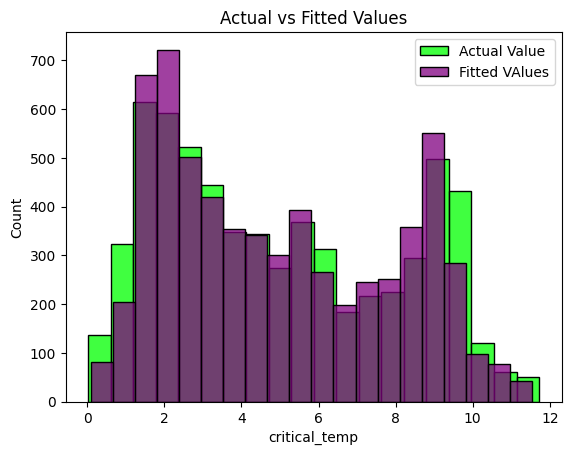

In [42]:
plot_dis(y_test, modelr.predict(X_test))

In [44]:
with open('vrg.pkl', 'wb') as arch:
    pickle.dump(modelr, arch)

# NEURAL NETWORK

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

In [46]:
X = df.drop(columns=['critical_temp']).values
y = df['critical_temp'].values

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

In [49]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [50]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.1)
        self._init_weights()

    def _init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='linear')

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        return self.out(x)

In [72]:
input_dim = X_train.shape[1]
model = MLPRegressor(input_dim)

In [73]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [74]:
train_dataset = TensorDataset(X_train, y_train)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [75]:
epochs = 200
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")

Epoch [20/200] - Loss: 1.2338
Epoch [40/200] - Loss: 1.1638
Epoch [60/200] - Loss: 1.8240
Epoch [80/200] - Loss: 0.9628
Epoch [100/200] - Loss: 1.7198
Epoch [120/200] - Loss: 1.7201
Epoch [140/200] - Loss: 1.3935
Epoch [160/200] - Loss: 1.4361
Epoch [180/200] - Loss: 1.6215
Epoch [200/200] - Loss: 0.6591


In [76]:
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()
    y_true = y_test.numpy()
    mse = mean_squared_error(y_true, preds)
    r2 = r2_score(y_true, preds)

print(f"\nMSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


MSE: 0.9134
R²: 0.9015


In [77]:
y_predicted = preds

Mean squared error: 0.9134435653686523
Mean absolute error: 0.7058948278427124
Explained variance score: 0.9019206166267395
R2 score: 0.9014603495597839


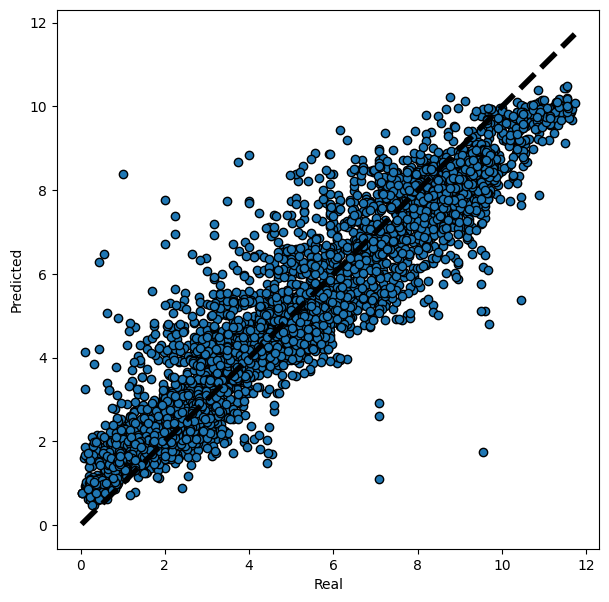

In [78]:
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))
# Plotea los valores reales vs los predichos en el conjunto de validacion
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

In [79]:
train_dataset = TensorDataset(X_train, y_train)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [81]:
model = MLPRegressor(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.MSELoss()

In [84]:
total_epochs = 200
num_snapshots = 4
epochs_per_cycle = total_epochs // num_snapshots
scheduler = CosineAnnealingLR(optimizer, T_max=epochs_per_cycle)
snapshots = []

In [85]:
for epoch in range(total_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    # Scheduler step (ajusta el learning rate)
    scheduler.step()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")
    # Guardar snapshot al final de cada ciclo
    if (epoch + 1) % epochs_per_cycle == 0:
        print(f"Guardando snapshot en epoch {epoch+1}")
        # Guardar una copia del estado del modelo (o modelo entero)
        snapshot = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        snapshots.append(snapshot)

Epoch [20/200] - Loss: 1.5553
Epoch [40/200] - Loss: 0.4649
Guardando snapshot en epoch 50
Epoch [60/200] - Loss: 0.7231
Epoch [80/200] - Loss: 1.1703
Epoch [100/200] - Loss: 2.3018
Guardando snapshot en epoch 100
Epoch [120/200] - Loss: 0.7719
Epoch [140/200] - Loss: 1.8942
Guardando snapshot en epoch 150
Epoch [160/200] - Loss: 1.7248
Epoch [180/200] - Loss: 3.2702
Epoch [200/200] - Loss: 0.6714
Guardando snapshot en epoch 200


In [86]:
def predict_with_ensemble(model_class, snapshots, X):
    model = model_class(input_dim=X.shape[1])
    model.eval()
    preds = []
    with torch.no_grad():
        for state_dict in snapshots:
            model.load_state_dict(state_dict)
            preds.append(model(torch.tensor(X, dtype=torch.float32)).numpy())
    return sum(preds) / len(preds)

In [87]:
y_predicted = predict_with_ensemble(MLPRegressor, snapshots, X_test)

Mean squared error: 0.946516215801239
Mean absolute error: 0.730527400970459
Explained variance score: 0.8987967371940613
R2 score: 0.8978925347328186


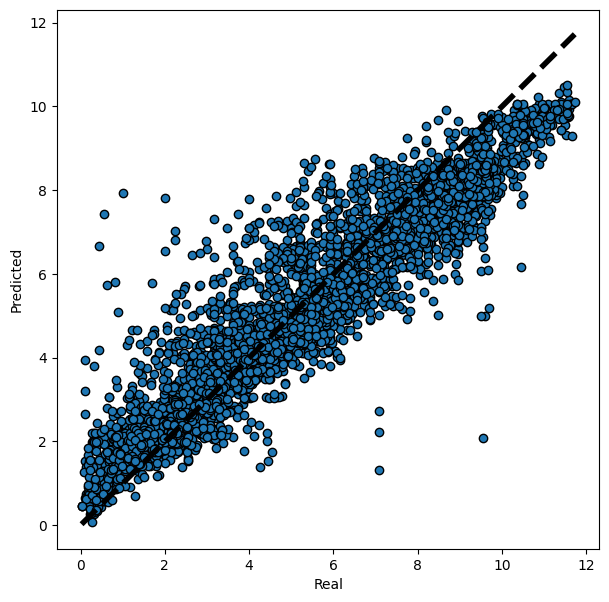

In [88]:
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))
# Plotea los valores reales vs los predichos en el conjunto de validacion
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()